### **Movies - Images and Text -- Assignment [10pts]**

In this assignment, we will be dealing with a significantly larger and more realistic dataset consisting of both images and text. For this assignment we will use the MMIMDB dataset (https://github.com/johnarevalo/gmu-mmimdb), collected by Arévalo, González, Solorio and Montes-y-Gómez from the Universidad Nacional de Colombia, University of Houston, INAOE-México. This dataset contains data corresponding to ~26,000 movies along with their plots (text) and their movie posters (images), and other information such as ratings and genres (categories). These are more movies than we will watch in a lifetime. We will use this dataset for movie genre classification. Each movie can be labeled with 27 categories of movies.

#### **1. Loading and Exploring the Dataset.**

##### **1.1 Dataset Download and Extraction**

First, we download the dataset, then we will create a Dataset class to load both the input movie posters (images), and input movie plots (texts), and the target movie genres (labels). We will also integrate the BertTokenizer from the huggingface transformers library so that the texts are pre-tokenized as they are loaded. The images however will be loaded on the fly as they can not all fit into memory.

In [1]:
!wget -nc http://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
!wget -nc http://www.cs.virginia.edu/~vicente/vislang/mmimdb-256.tar.gz
# I found downloading from Google Drive with gdown is a lot faster.
!pip -q install gdown
!gdown https://drive.google.com/uc?id=173IhB80sQj2QfzTa10EsoUeEirb7LLlE
!tar xf mmimdb-256.tar.gz
#!tar xf mmimdb-512.tar.gz # I also keep a copy with images resized at 512 pixels on their largest side.
!pip install livelossplot --quiet
!pip -q install transformers

--2022-02-23 02:11:51--  http://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz [following]
--2022-02-23 02:11:51--  https://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643479473 (614M) [application/x-gzip]
Saving to: ‘mmimdb-256.tar.gz’

mmimdb-256.tar.gz   100%[===================>] 613.67M  2.81MB/s    in 3m 42s  

2022-02-23 02:15:33 (2.77 MB/s) - ‘mmimdb-256.tar.gz’ saved [643479473/643479473]

File ‘mmimdb-256.tar.gz’ already there; not retrieving.

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission

##### **1.2 Defining the Data Loader**
This is a typical step in your course project that you will need to complete. Find some dataset, define your task, then get to know your data well enough so that you can write a data loader for it. Don't take this work for granted. It is hard work. Please take some time analyzing the code below and if you have questions feel free to ask on Piazza. Play especially close attention to the part of the code used for tokenizing the text. This is a special preprocessing step in NLP that doesn't typically apply to images.

In [2]:
import torch, os, json
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from PIL import Image

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'dataset-resized-256max', split = 'dev',
                 image_transform = None):
        self.json_dir = os.path.join(folder, split, 'metadata')
        self.image_dir = os.path.join(folder, split, 'images')
        self.image_transform = image_transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Category definitions of movies.
        self.categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 
                           'Family', 'Fantasy', 'Film-Noir', 'History', 
                           'Horror', 'Music', 'Musical', 'Mystery', 'News', 
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname)))) 
                     for fname in sorted(fdir) if not fname.startswith('.')]
        print(' finished')

        # Pre-tokenizing all sentences.
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        for i in range(0, len(self.metadata)):
            text = self.metadata[i][1]['plot'][0]
            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')
            self.tokenized_plots.append(encoded_text)
        print(' finished')
            
    def __getitem__(self, index: int):
        # Load images on the fly.
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        text = self.tokenized_plots[index]['input_ids'][0]
        text_mask = self.tokenized_plots[index]['attention_mask'][0]
        genres = movie_data['genres']

        if self.image_transform: image = self.image_transform(image)

        # Encode labels in a binary vector.
        label_vector = torch.zeros((len(self.categories)))
        label_ids = [self.categories2ids[cat] for cat in genres]
        label_vector[label_ids] = 1

        return image, text, text_mask, label_vector

    def load_image_only(self, index: int):
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        return image

    def get_metadata(self, index: int):
        _, movie_data = self.metadata[index]
        return movie_data

    def __len__(self):
        return len(self.metadata)

val_data = MovieDataset(split = 'dev')
print('Data size: %d samples' % len(val_data))

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished
Data size: 2608 samples


##### **1.3 Testing the data loader**
Printing one element from this dataset, both the plot, movie poster, labels, and some of the other metadata. Do not move to the following cells until you understand every line in the code above and below.

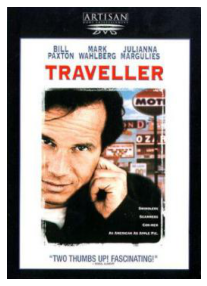

['a', 'young', 'man', ',', 'pat', ',', 'visits', 'the', 'clan', 'of', 'gypsy', '-', 'like', 'gr', '##if', '##ters', '(', 'irish', 'travellers', ')', 'in', 'rural', 'north', 'carolina', 'from', 'whom', 'he', 'is', 'descended', '.', 'he', 'is', 'at', 'first', 'rejected', ',', 'but', 'cousin', 'bo', '##kk', '##y', 'takes', 'him', 'on', 'as', 'an', 'apprentice', '.', 'pat', 'learns', 'the', 'game', 'while', 'bo', '##kk', '##y', 'falls', 'in', 'love', 'and', 'desires', 'a', 'different', 'life', '.']
a young man , pat , visits the clan of gypsy - like grifters ( irish travellers ) in rural north carolina from whom he is descended . he is at first rejected , but cousin bokky takes him on as an apprentice . pat learns the game while bokky falls in love and desires a different life .
['Crime', 'Drama', 'Romance']
Title:  Traveller
Kind:  movie
Year:  1997
Rating:  6.2


In [3]:
import numpy as np

sample_movieID = 1247
img, text, text_mask, labels = val_data[sample_movieID]

# Show input image.
plt.figure(figsize=(4,5));plt.imshow(img); plt.axis(False);plt.show()

# Show input plot (untokenized).
tokens = val_data.tokenizer.convert_ids_to_tokens(text, skip_special_tokens = True)
print(tokens)
print(val_data.tokenizer.convert_tokens_to_string(tokens))

# Show target labels (converted back to strings from binary vector).
labels = labels.numpy()
# Is there a better way to do this?
print([val_data.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])

# You can look at other attributes for the movies on this dataset.
movie_metadata = val_data.get_metadata(sample_movieID)
print('Title: ', movie_metadata['smart canonical title'])
print('Kind: ', movie_metadata['kind'])
print('Year: ', movie_metadata['year'])
print('Rating: ', movie_metadata['rating'])

##### **1.4 Visualizing a group of samples**
We explore below some of the images in the dataset that belong to the category `Comedy`.

There are 873 movies of type Comedy among 2608


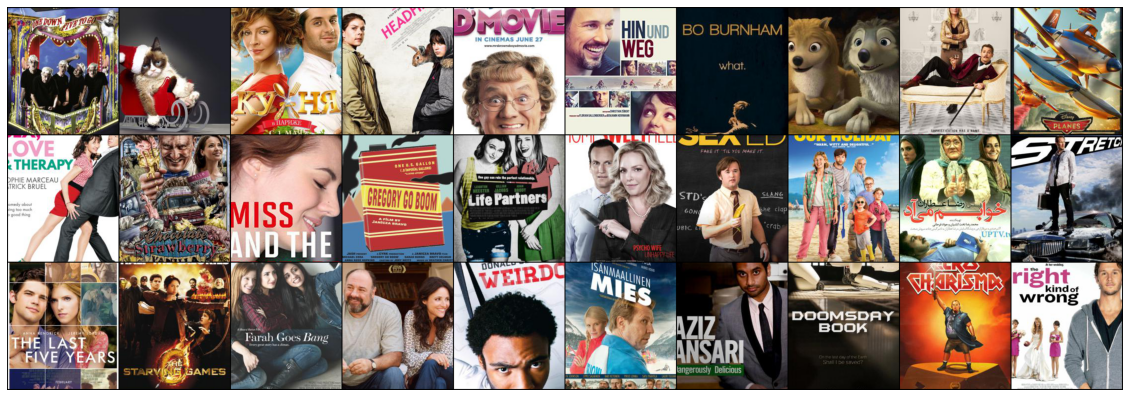

In [4]:
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

# Now let's display a bunch of posters for Crime movies.
movieType = 'Comedy'
crime_ids = [id for id in range(0, len(val_data)) \
             if movieType in set(val_data.get_metadata(id)['genres'])]

print('There are %d movies of type %s among %d' % 
      (len(crime_ids), movieType, len(val_data)))

def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));

# I'm passing the ids in reverse order, because it seems the movies are
# ordered from old to new in the dataset. Try the other way.
show_image_group(val_data, crime_ids[::-1], 30)

#### **2. Classify the Movies into Genres (based on their Plots -- Text) [2pts]**

For this assignment we will not just use BERT encodings but we will use a pretrained BERT model and "fine-tune" its parameters to they adapt to the text in this dataset. This is commonly referred as transfer learning. You can try compare it to a simpler bag-of-words model but this is left as an exercise on your own.

##### **2.1. Setting up Data Loaders**

In the code below, we are loading the training, and validation splits and then testing the batch loaders.

In [5]:
# Let's setup the data loaders and preprocessing.
import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 10

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)
valset = MovieDataset(split = 'dev', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

Loading dataset-resized-256max/train/metadata ... finished
Tokenizing... finished
Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished


Testing what a sample batch looks like.

In [6]:
(imgs, texts, text_masks, labels) = next(iter(val_loader))
print(imgs.shape, texts.shape, text_masks.shape, labels.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27])


##### **2.2. Loading the predefined BERT Transformer Model**

Here we initialize the pretrained BERT model from the huggingface transformers library. They have several slightly different versions of it that are slightly modified for different tasks so you don't need to manually modify it (e.g. replacing last layer with something else) for your particular task. Do not be surprised if Google Colab keeps crashing. This is a very heavy model so I would recommend only running this cell once. Or if you have to run it twice, you might have to restart the runtime.

In [7]:
from transformers import BertForSequenceClassification, BertConfig

# Loading BERT...
num_categories = len(trainset.categories)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = num_categories,  output_attentions = False, 
    output_hidden_states = False)

# Let's run a quick test on this model on the CPU.
output = model(texts, text_masks)
print(output.logits.shape)

# Tell pytorch to run this model on the GPU.
model.cuda();

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

torch.Size([10, 27])


##### **2.3. Training Loop for finetuning this BERT Model**
Not very different than a training loop for training a model based on convolutional neural networks. However, please pay close attention to the differences. 

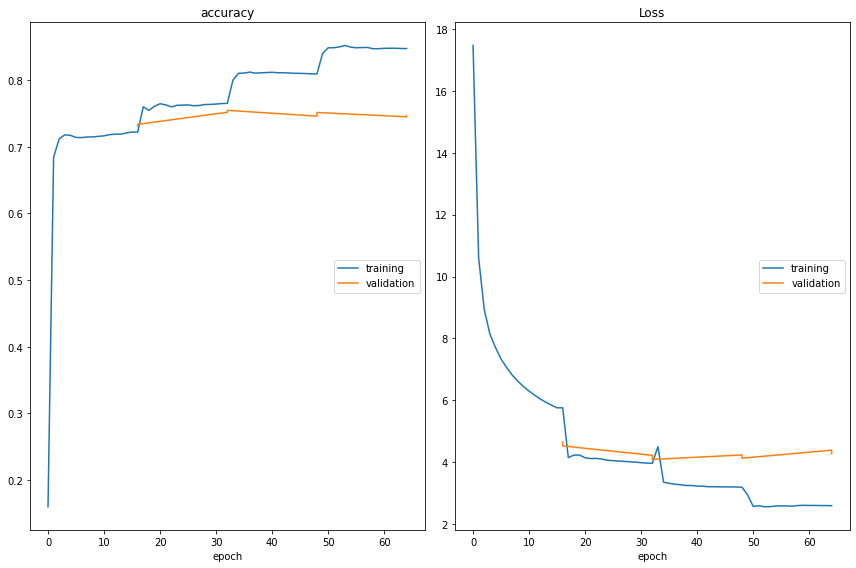

accuracy
	training         	 (min:    0.160, max:    0.852, cur:    0.847)
	validation       	 (min:    0.731, max:    0.755, cur:    0.747)
Loss
	training         	 (min:    2.562, max:   17.465, cur:    2.596)
	validation       	 (min:    4.091, max:    4.653, cur:    4.280)


In [8]:
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

num_epochs = 4

# Following recommendations from the BERT paper and also this
# blog post https://mccormickml.com/2019/07/22/BERT-fine-tuning/
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# Are the top five scored labels accurate?
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

# Training Loop. 
best_accuracy = 0
liveloss = PlotLosses(); current_step = 0
for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        texts = texts.cuda()
        text_masks = text_masks.cuda()
        labels = labels.cuda()

        # Compute predictions.
        predicted = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted.logits, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
        # Move to GPU.
        texts = texts.cuda()
        text_masks = text_masks.cuda()
        labels = labels.cuda()

        # Compute predictions.
        predicted = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted.logits, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
        num_samples += texts.size(0)

        if (1 + batch_id) % 100 == 0:
            logs['val_loss'] = cumulative_loss / num_samples
            logs['val_accuracy'] = cumulative_accuracy / num_samples    
            liveloss.update(logs, current_step)
            liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth') 

##### **2.4. Loading model weights from a file**
Training the model in the previous section might take about an hour -- instead we can load a model that has been pretrained already. Feel free to retrain but here I provide a model I trained myself by running the code in the preceding section.

In [ ]:
# I uploaded a "checkpoint" of this model that I trained on Google Drive.
# Try saving and uploading your model to Google Drive as well.
!gdown https://drive.google.com/uc?id=1WuLFvQLMd0_Nmpjp7aDRIovWtOiRRyRd
model.load_state_dict(torch.load('best_model_so_far-comp646-spring2022.pth'))
model.eval();

##### **2.5 Show the predictions for a few input texts [1pt]**
Show the top five classification predictions of the BERT model for a few input plots, as shown below. In order to obtain probability scores you need to understand what the nn.BCEWithLogitsLoss is doing when training the prediction scores. Take into account that since we are dealing with multi-class classification, this is not a softmax classifier trained with a cross entropy loss (nn.CrossEntropyLoss), ie. prediction scores don't add up to 1.

In [17]:
rand_number = [33, 25, 43, 111]
for i in rand_number:
    img, text, text_mask, labels = val_data[i]
    # # Show input plot (untokenized).
    tokens = val_data.tokenizer.convert_ids_to_tokens(text, skip_special_tokens = True)
    word = val_data.tokenizer.convert_tokens_to_string(tokens)
    Split = 6
    Part = len(word)//Split

    print('#'*(Part//2),' '*5, 'Input_Id =',i,' '*5, '#'*(Part//2))
    print('#'* (Part+27))

    for i in range(Split):
      if i == Split-1:
        print(word[i*Part+1:])
      else:
        print(word[i*Part:i*Part+Part])
    print('#'* (Part+27))
    text = torch.reshape(text, [-1, 256]).cuda()
    text_mask = torch.reshape(text_mask, [-1,256]).cuda()
    predicted = model(text, text_mask)
    logit = predicted[0].sigmoid()
    Best_Five_P, Best_Five_Indice = torch.topk(logit, 5)

    for i,j in zip(Best_Five_Indice[0].cpu().numpy(),Best_Five_P[0].cpu().detach().numpy()):
      print('P['+str(val_data.categories[i])+'] = ', j)

    labels = labels.numpy()
    print('Ground Truth Labels:',[val_data.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])
    print()

##############       Input_Id = 33       ##############
#######################################################
farmer sweetland is a lonely
 old widower . he is determi
ned to marry again and he en
lists the help of his housek
eeper minta to pick a wife f
om the local single women .
#######################################################
P[Comedy] =  0.86740816
P[Romance] =  0.76692337
P[Drama] =  0.71067995
P[Musical] =  0.01524882
P[Family] =  0.00904954
Ground Truth Labels: ['Comedy', 'Drama', 'Romance']

#############################       Input_Id = 25       #############################
#####################################################################################
prince danilo falls in love with dancer sally o ' hara . h
is uncle , king nikita i of monteblanco forbids the marria
ge because she is a commoner . thinking she has been jilte
d by her prince , sally marries old , lecherous baron sado
ja , whose wealth has kept the kingdom afloat . when he di
s suddenly , sally

##### **2.6. Show the posters for movies labeld as Comedy with the highest confidence by the BERT model. [1pt]**

Use the show_image_group function provided earlier to show the top 30 images scored with the highest scores by the BERT model as Comedy. **Note:** I know the model is not scoring the movies based on the movie poster at all but it seems easier to judge by movie poster for a quick visual inspection as it doesn't require reading text.

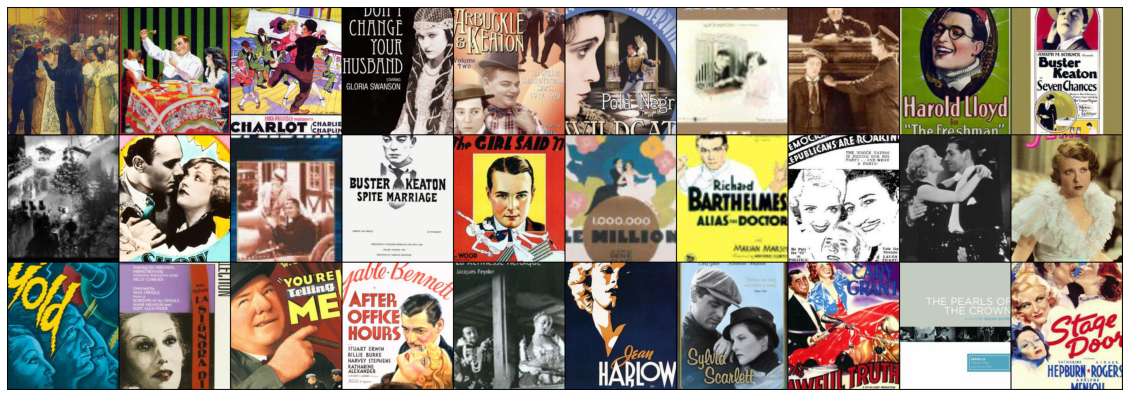

In [18]:
# Your code goes here.
rand_number = range(len(val_data))
Count_Id = []
for i in rand_number:
    img, text, text_mask, labels = val_data[i]
    # # Show input plot (untokenized).
    text = torch.reshape(text, [-1, 256]).cuda()
    text_mask = torch.reshape(text_mask, [-1,256]).cuda()
    predicted = model(text, text_mask)
    logit = predicted[0].sigmoid()
    Category_Number = torch.argmax(logit)
    if Category_Number == 5:
      Count_Id.append(i)
show_image_group(val_data,Count_Id,30)

#### **3. Classify the Movies into Genres (based on their Posters -- Images) [4pts]**



Feel free to discuss answers to these questions or share plots on Piazza -- but not code. Also I'm setting here a leaderboard again for this task [here](https://docs.google.com/spreadsheets/d/1p7ly7-VC3WiI5mtsy-xKfHVu8cwaYK1Eovmysfnasws/edit?usp=sharing). Please share your results so that your classmates know where their solution lies with respect to the rest of the class.

##### **3.1 Training the model [2pts]**
For this part feel free to re-use code from the previous sections, the previous assignment, and the previous assignment solutions, as appropriate. You have to at least show your training/validation accuracy and loss plots showing the model is learning and has converged.

In [60]:
# Your code goes here.
import torchvision.models as models
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

# Import Model
model_CNN = models.resnet34(pretrained=True)
# Extract Weights
fc_features = model_CNN.fc.in_features
# Output_Class = 27
model_CNN.fc = nn.Linear(fc_features, len(val_data.categories))
model_CNN.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [62]:
# Count Parameters
count_params = 0
for param in model.parameters():
 count_params += param.numel()
print(count_params)

109503003


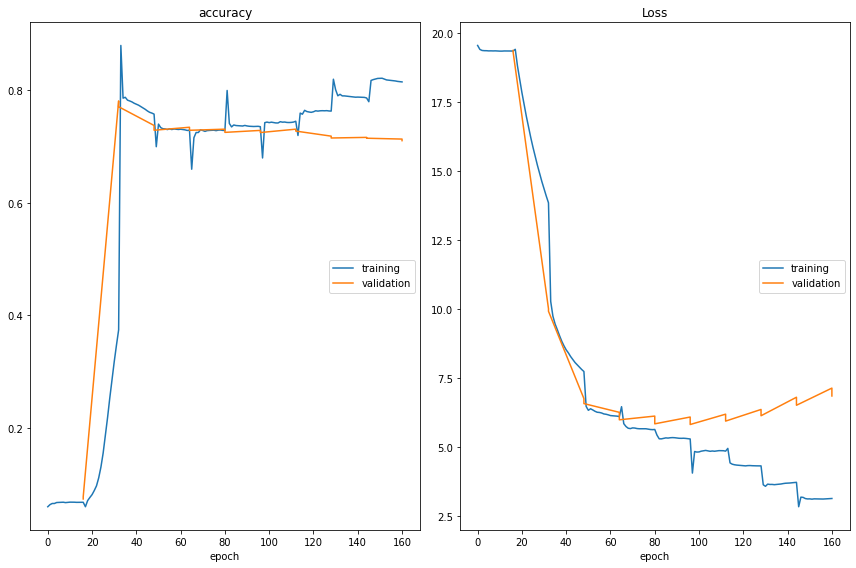

accuracy
	training         	 (min:    0.060, max:    0.880, cur:    0.815)
	validation       	 (min:    0.074, max:    0.781, cur:    0.711)
Loss
	training         	 (min:    2.835, max:   19.553, cur:    3.134)
	validation       	 (min:    5.815, max:   19.373, cur:    6.850)


In [61]:
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

num_epochs = 10

optimizer = torch.optim.AdamW(model_CNN.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 10, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# top five scored labels accurate
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

# Training Loop. 
best_accuracy = 0
liveloss = PlotLosses(); current_step = 0
for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model_CNN.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        labels = labels.cuda()
        imgs = imgs.cuda()

        # Compute predictions.
        predicted = model_CNN(imgs)

        # Compute loss.
        loss = cost_function(predicted, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model_CNN.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model_CNN.eval()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
        # Move to GPU.
        imgs = imgs.cuda()
        labels = labels.cuda()

        # Compute predictions.
        predicted = model_CNN(imgs)

        # Compute loss.
        loss = cost_function(predicted, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
        num_samples += texts.size(0)

        if (1 + batch_id) % 100 == 0:
            logs['val_loss'] = cumulative_loss / num_samples
            logs['val_accuracy'] = cumulative_accuracy / num_samples    
            liveloss.update(logs, current_step)
            liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    # if logs['val_accuracy'] > best_accuracy:
    #     best_accuracy = logs['val_accuracy']
    #     torch.save(model.state_dict(), 'best_model_so_far.pth') 

**Required answer:** Is this model better than the text classifier in terms of top-5 accuracy as computed earlier? Which one is better?

**Answer**: Yes, ResNet34 with pre-warmup trick can perform better than BERT (But I think BERT can beat CNN in my tuition if we also use warm-up trick for BERT).

##### **3.2 Analysis [0.5pt]**
Show the images classified as "Comedy" with the highest confidence using the above image classifier (show their posters).

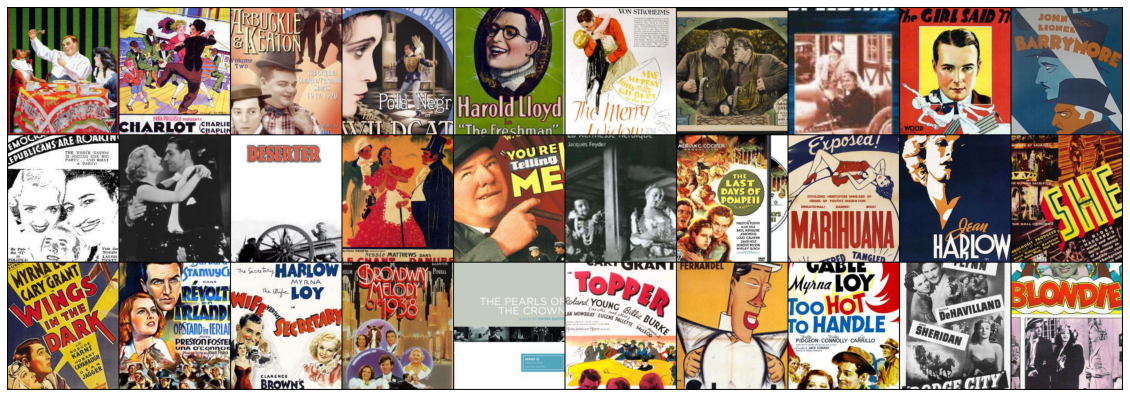

In [47]:
# Your code goes here.
Count_Id_CNN = []
for i in range(len(val_data)):
    img, text, text_mask, labels = val_data[i]
    # # Show input plot (untokenized).
    img = image_transform(img)
    img = img[None].cuda()
    predicted = model_CNN(img)
    P = predicted.sigmoid()
    Category_Number = torch.argmax(P)
    if Category_Number == 5:
        Count_Id_CNN.append(i)
    # if len(Count_Id_CNN) == 30:
    #   break

show_image_group(val_data,Count_Id_CNN,30)

##### **3.3 Show Predictions [0.5pt]**
For a given movie, show its plot, poster, and the predictions of the plot classifier and the poster classifier.

##################################       Input_Id = 4       ##################################
#####################################################################
sam bisbee is an inventor whose works ( e . g . , a keyhole finder fo
r drunks ) have brought him only poverty . his daughter is in love wi
th the son of the town snob . events conspire to ruin his bullet - pr
oof tire just as success seems near . another of his inventions prohi
its him from committing suicide , so sam decides to go on living . .
#####################################################################
CNN Predict:
P[Comedy] = 0.8271949
BERT Predict:
P[Comedy] = 0.97227234


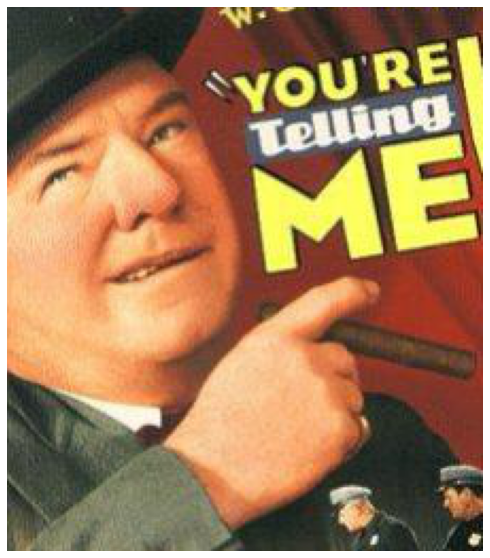

In [50]:
# Your code goes here.
random_sample = 73
img, text, text_mask, labels = val_data[random_sample]
# # Show input plot (untokenized).

img = image_transform(img)
img = img[None].cuda()
predicted_CNN = model_CNN(img)
P_CNN = predicted_CNN.sigmoid()
Prob_CNN, Category_Number_CNN = torch.topk(P_CNN,1)

tokens = val_data.tokenizer.convert_ids_to_tokens(text, skip_special_tokens = True)
word = val_data.tokenizer.convert_tokens_to_string(tokens)
Split = 5
Part = len(word)//Split

print('#'*(Part//2),' '*5, 'Input_Id =',i,' '*5, '#'*(Part//2))
print('#'* Part)

for i in range(Split):
  if i == Split-1:
    print(word[i*Part+1:])
  else:
    print(word[i*Part:i*Part+Part])
print('#'* Part)

text = torch.reshape(text, [-1, 256]).cuda()
text_mask = torch.reshape(text_mask, [-1,256]).cuda()
predicted_BERT = model(text, text_mask)
P_BERT = predicted_BERT[0].sigmoid()
Prob_BERT, Category_Number_BERT = torch.topk(P_BERT,1)

# Plot Model Part
show_image_group(val_data,[random_sample],1)
print('CNN Predict:')
print('P['+str(val_data.categories[Category_Number_CNN])+'] =',Prob_CNN[0][0].cpu().detach().numpy())
print('BERT Predict:')
print('P['+str(val_data.categories[Category_Number_BERT])+'] =',Prob_BERT[0][0].cpu().detach().numpy())


##### **3.3 Further Analysis [1pt]**
 Is there an overlap in the top 100 images rated as Comedy by the text classifiers and the image classifier? How big is this overlap?

In [52]:
# Compute the overlap here.
Count_Id_CNN_100 = [i for i  in Count_Id_CNN if i <=100]
Count_Id_Bert_100 = [i for i  in Count_Id if i <=100]
InterSection_100  = list(set(Count_Id_CNN_100) & set(Count_Id_Bert_100))
print('Total Bert Comedy:',len(Count_Id_Bert_100))
print('Total CNN Comedy:', len(Count_Id_CNN_100))
print('Overlap Number:', len(InterSection_100))

Total Bert Comedy: 30
Total CNN Comedy: 25
Overlap Number: 13


#### **4. Multimodal Models (Text + Images) [4pts]**

##### **4.1 Late-fusion Model**

Below I define a multimodal model that can be potentially trained with both images and text. It combines the outptus of a text model and an image model and concatenates them before passing them through a final linear layer.

In [ ]:
from transformers import BertModel, BertConfig

class MultiModalMovieModel(torch.nn.Module):
    def __init__(self):
        super(MultiModalMovieModel, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased',   
                                    output_attentions = False,  
                                    output_hidden_states = True)
        
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = (5, 5), stride = 4)
        self.conv2 = torch.nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = (3, 3), stride = 2)
        self.linear1 = torch.nn.Linear(in_features = 32 * 3 * 3, out_features = 256)
        self.linear2 = torch.nn.Linear(in_features = 256 + 768, out_features = 27)

    def forward(self, img, text, text_mask):

        # Compute the text feature outputs out of the BERT model.
        text_features = self.bert(text, text_mask).pooler_output

        # First conv layer + maxpool2d + relu.

        x = self.conv1(img)
        x = torch.nn.functional.max_pool2d(x, (4, 4))
        x = torch.nn.functional.relu(x)

        # Second conv layer + maxpool2d + relu.
        x = self.conv2(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)

        # Vectorize except along the batch dimension.
        # You can always print here x.shape to see what it looks like.
        x = x.view(x.size(0), -1)

        # Pass through linear layers.
        image_features = self.linear1(x)

        # Cobmine the image and text features through concatenation.
        combined_features = torch.cat((image_features, text_features), 1)

        # Pass the combined features thorugh a linear layer and output.
        x = torch.nn.functional.relu(combined_features)
        x = self.linear2(x)

        return x

In [ ]:
# Sample input data.
img, text, text_mask, labels = next(iter(val_loader))
img = img.cuda()
text = text.cuda()
text_mask = text_mask.cuda()
labels = labels.cuda()
# Create model.
my_model = MultiModalMovieModel()
my_model = my_model.cuda()

# Make predictions.
predictions = my_model(img, text, text_mask)

# This shouldn't print any errors.
print(img.shape, text.shape, text_mask.shape, labels.shape, predictions.shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27]) torch.Size([10, 27])


##### **4.2 FiLM: Feature-wise Linear Modulation [4pts]**

In 2017 a paper was written by Ethan Perez, an undergraduate student at Rice University, and collaborators at other institutions. This paper has been influential in work combining outputs from two modalities. Instead of just combining the outputs of each modality at the end -- they propose to combine them across several layers in the middle. To earn points here you need to read the paper and modify the neural network below so that it uses the technique described in this work: https://arxiv.org/pdf/1709.07871.pdf. You can also read a more friendly introduction to this technique here: https://distill.pub/2018/feature-wise-transformations/ and here: https://ml-retrospectives.github.io/neurips2019/accepted_retrospectives/2019/film/

Concretely, modify the network below so that instead of late-fusion using concatenation-based fusion, the text_features are used for feature-wise modulation of the outputs of the second convolutional layer. Please provide your own implementation for the required operation in FiLM. It doesn't need to be general -- as long as it works for this particular instance.

In [ ]:
from transformers import BertModel, BertConfig
from torch import nn
class FiLMBlock(nn.Module):
    def __init__(self):
        super(FiLMBlock, self).__init__()
        
    def forward(self, x, gamma, beta):
        print(x.size(0), x.size(1))
        beta = beta.view(x.size(0), x.size(1), 1, 1)
        gamma = gamma.view(x.size(0), x.size(1), 1, 1)
        x = gamma * x + beta
        
        return x

class MultiModalMovieModel(torch.nn.Module):
    def __init__(self):
        super(MultiModalMovieModel, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased',   
                                    output_attentions = False,  
                                    output_hidden_states = True)
        
        self.Feature_Reduce = torch.nn.Linear(in_features = 768, out_features = 32)
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = (5, 5), stride = 4)
        self.conv2 = torch.nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = (3, 3), stride = 2)
        self.conv3 = torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3))
        self.BatchNorm1 = torch.nn.BatchNorm2d(num_features = 32)
        self.film = FiLMBlock()

        self.linear1 = torch.nn.Linear(in_features = 32 * 3 * 3, out_features = 256)
        self.linear2 = torch.nn.Linear(in_features = 256, out_features = 27)

    def forward(self, img, text, text_mask):

        # Compute the text feature outputs out of the BERT model.
        text_features = self.bert(text, text_mask).pooler_output
        text_reduce_gamma = self.Feature_Reduce(text_features)
        text_reduce_beta = self.Feature_Reduce(text_features)

        # First conv layer + maxpool2d + relu.
        x = self.conv1(img)
        x = torch.nn.functional.max_pool2d(x, (4, 4))
        x = torch.nn.functional.relu(x)

        # Second conv layer + maxpool2d + relu.
        x = self.conv2(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        identity = torch.nn.functional.relu(x) # 10 x 32 x 3 x 3

        # Feature-Wise Modulation Block
        x = self.conv3(identity)
        x = self.BatchNorm1(x)
        x = self.film(x, text_reduce_gamma, text_reduce_beta)
        x = torch.nn.functional.relu(x)
        x = x + identity

        # Vectorize except along the batch dimension.
        # You can always print here x.shape to see what it looks like.
        x = x.view(x.size(0), -1)

        # Pass through linear layers.
        x = self.linear1(x)

        # Pass the combined features thorugh a linear layer and output.
        x = torch.nn.functional.relu(x)
        x = self.linear2(x)

        return x

In [ ]:
# Sample input data.
img, text, text_mask, labels = next(iter(val_loader))
img = img.cuda()
text = text.cuda()
text_mask = text_mask.cuda()
labels = labels.cuda()

# Create model.
my_model = MultiModalMovieModel()
my_model = my_model.cuda()
# Make predictions.
predictions = my_model(img, text, text_mask)

# This shouldn't print any errors.
print(img.shape, text.shape, text_mask.shape, labels.shape, predictions.shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


10 32
torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27]) torch.Size([10, 27])
